### Import required libraries

In [1]:
import tensorflow as tf

# print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from numpy import array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout, Softmax
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
# from sklearn.metrics import root_mean_squared_error as RMSE
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
!pip install netron
import netron
from random import randint

First of all, we define this function which split a given sequence into multiple samples where each sample has a specified number of time steps and a specifieded number of outputs.

In [3]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## Data preprocessing

We import data and remove the index. 

In [4]:
data=pd.read_csv('../../Datasets/PSM(t-24).csv')
index = data['clave']
data=data.drop(['clave'], axis=1)
print(data)
print(index)

       var1(t-24)  var2(t-24)  var3(t-24)  var4(t-24)  var5(t-24)  var6(t-24)  \
0            91.0      1937.0       794.0        76.0         0.0        36.0   
1           109.0      1507.0       568.0        76.0         0.0        36.0   
2            92.0       758.0       199.0        76.0         0.0        36.0   
3            98.0       549.0       146.0        76.0         0.0        36.0   
4           118.0       467.0       107.0        76.0         0.0        36.0   
...           ...         ...         ...         ...         ...         ...   
31362      2263.0      1756.0       515.0       270.0         0.0       199.0   
31363      2188.0      1966.0       461.0       270.0         0.0       199.0   
31364      2268.0      2049.0       430.0       270.0         0.0       199.0   
31365      1879.0      1771.0       351.0       270.0         0.0       199.0   
31366      1699.0      1312.0       241.0       270.0         0.0       199.0   

       var7(t-24) var8(t-24

We encode the categorical variable 'type of day'.

In [5]:
encoder = LabelEncoder()
data[data.columns[7]] = encoder.fit_transform(data[data.columns[7]])


We add the variable 'hour'. 

In [6]:
a1=list(range(1,24))
a2=list(range(0,24))*1305
a3=list(range(0,24))
a4=a1+a2+a3
data['hour'] = a4
data = data.reindex(columns=[data.columns[0],data.columns[1],data.columns[2],data.columns[3],data.columns[4],
                             data.columns[5],data.columns[6],data.columns[7],'hour','obj'])
data

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),hour,obj
0,91.0,1937.0,794.0,76.0,0.0,36.0,116.0,1,1,26
1,109.0,1507.0,568.0,76.0,0.0,36.0,116.0,1,2,18
2,92.0,758.0,199.0,76.0,0.0,36.0,116.0,1,3,20
3,98.0,549.0,146.0,76.0,0.0,36.0,116.0,1,4,33
4,118.0,467.0,107.0,76.0,0.0,36.0,116.0,1,5,168
...,...,...,...,...,...,...,...,...,...,...
31362,2263.0,1756.0,515.0,270.0,0.0,199.0,341.0,2,19,256
31363,2188.0,1966.0,461.0,270.0,0.0,199.0,341.0,2,20,270
31364,2268.0,2049.0,430.0,270.0,0.0,199.0,341.0,2,21,281
31365,1879.0,1771.0,351.0,270.0,0.0,199.0,341.0,2,22,209


We normalise all input variables. 

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[data.columns.difference(['obj'])] = scaler.fit_transform(data[data.columns.difference(['obj'])])

We apply the previously defined function. We split the original sequence data. Each sample has six time steps as predictor variables (from timestep t-15 to timestep t-12) and one target variable (timestep t). 

In [8]:
data1=data.values
X, y = split_sequences(data1,4,1)
print(X.shape)
print(y.shape)

(31364, 4, 9)
(31364, 1)


## Data analyse

We make a simple statistical analysis of the target variable. 

In [9]:
dataplot = data
dataplot['obj'].describe()

count    31367.000000
mean       437.287882
std        325.351794
min          0.000000
25%        130.000000
50%        388.000000
75%        705.000000
max       3762.000000
Name: obj, dtype: float64

We plot linechart of the evolution of traffic flow in the first week of 2018 (first available data). 

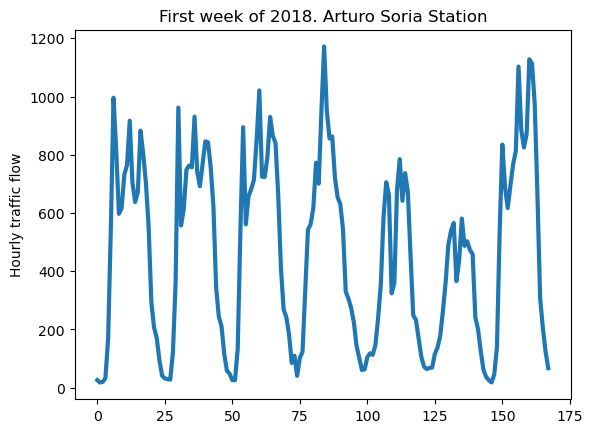

In [10]:
plt.plot(list(dataplot['obj'][0:24*7]),
        label=index, linewidth=3)
plt.title('First week of 2018. Arturo Soria Station')
plt.ylabel('Hourly traffic flow')
plt.show()

## Model development. 

We reshape our data to have the structure required by the neural network. 

In [11]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2])).astype('float32')


We divide randomly our data in the train and test sets. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

We develop our model by using keras and tensorflow. First, we apply a convolutional neural network with 256 kernels which is followed by a max pooling. Then, we flatten data. 

Subsequently, we use the flatten data as input in the Bidirectional long short term memory network, with 500 units. It is followed by a dropout layer and, finally, we apply a dense layer to obtain the required prediction. 

In [13]:
# Define your input shape
input_shape = (4, 9, 1)

# Create the input layer
input_layer = Input(shape=input_shape)

# Apply Conv1D with soft attention
conv_layer = TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu'))(input_layer)

# Apply MaxPooling1D
pooling_layer = TimeDistributed(MaxPooling1D(pool_size=2, padding='same'))(conv_layer)

# Flatten the output
flatten_layer = TimeDistributed(Flatten())(pooling_layer)

# Bidirectional GRU layer
gru_layer = GRU(500, activation='relu', return_sequences=True)(flatten_layer)

# dropout_layer = Dropout(0.5)(gru_layer)
# Dense layers
denselayer1 = Dense(1000)(gru_layer)
denselayer2 = Dense(1000)(denselayer1)

# Apply soft attention mechanism
attention_weights = Softmax(axis=1)(denselayer2)
attended_output = denselayer2 * attention_weights

# Apply AveragePooling1D
pooled_output = AveragePooling1D(pool_size=4)(attended_output)

# Reshape the pooled tensor to (None, 1000)
reshaped_output = tf.keras.layers.Reshape(target_shape=(1000,))(pooled_output)

# Output layer
output_layer = Dense(1)(reshaped_output)

# Compile the model
model_with_attention = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_with_attention.compile(optimizer='adam', loss='mae')

# Summary of the modified model
model_with_attention.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 4, 9, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 4, 8, 256)         │             768 │ input_layer[0][0]          │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_1            │ (None, 4, 4, 256)         │               0 │ time_distributed[0][0]     │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_2            │ (None, 4, 1024)           │               0 │ time_distributed_1[0][0]   │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru (GRU)                     │ (None, 4, 500)            │       2,289,000 │ time_distributed_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 4, 1000)           │         501,000 │ gru[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 4, 1000)           │       1,001,000 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ softmax (Softmax)             │ (None, 4, 1000)           │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 4, 1000)           │               0 │ dense_1[0][0],             │
│                               │                           │                 │ softmax[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling1d             │ (None, 1, 1000)           │               0 │ multiply[0][0]             │
│ (AveragePooling1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1000)              │               0 │ average_pooling1d[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           1,001 │ reshape[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,792,769 (14.47 MB)

 Trainable params: 3,792,769 (14.47 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# model3.summary()

In [15]:
print(y_train.shape)

(21013, 1)


We provide a graphical representation of the model by using Netron. Reader can deeply analyse each layer of the model. 

In [16]:

# model_with_attention.save('model_with_attention.keras')
# netron.start('model_with_attention.h5')

We train the model.

In [17]:
%%time

history3=model_with_attention.fit(X_train,y_train,epochs=100,batch_size = 32, shuffle=True,validation_data=(X_test,y_test))

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - loss: 218.9526 - val_loss: 138.6915
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 125.4609 - val_loss: 120.5108
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 117.6308 - val_loss: 117.5282
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 110.9839 - val_loss: 107.1377
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 108.6702 - val_loss: 103.8152
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 104.9929 - val_loss: 102.4827
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 104.1442 - val_loss: 100.7986
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 98.8679 - val_loss: 105.2762
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 99.0815 - val_loss: 97.3367
Epoch 10/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 99.0547 - val_loss: 98.3691
Epoch 11/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 95.7812 - 

In [18]:
# import keras
# tf.keras.s(model_with_attention, 'model_with_attention_AS2(t-12).keras')
model_with_attention.save('model_with_attention_PSM(t-24).keras')

train_loss_pd = pd.DataFrame(history3.history['loss'])
val_loss_pd = pd.DataFrame(history3.history['loss'])
train_loss_pd.to_csv('train_loss_PSM(t-24)')
val_loss_pd.to_csv('val_loss_PSM(t-24)')

In [19]:
# print(history3.items())
history3.history

{'loss': [168.38922119140625,
  122.23149871826172,
  115.70582580566406,
  110.33705139160156,
  107.79251861572266,
  105.07786560058594,
  102.84266662597656,
  100.74313354492188,
  99.68702697753906,
  98.1768569946289,
  96.80499267578125,
  96.2338638305664,
  93.42820739746094,
  93.92657470703125,
  92.84386444091797,
  91.41641235351562,
  91.10951232910156,
  90.24871826171875,
  90.0403823852539,
  89.19620513916016,
  88.60860443115234,
  87.97091674804688,
  86.87733459472656,
  86.19715881347656,
  86.70089721679688,
  86.27733612060547,
  85.22305297851562,
  85.01138305664062,
  84.20122528076172,
  83.4362564086914,
  83.33137512207031,
  83.12269592285156,
  82.49153900146484,
  82.05641174316406,
  81.56079864501953,
  81.54839324951172,
  80.34557342529297,
  80.07635498046875,
  79.60521697998047,
  79.18077087402344,
  79.62137603759766,
  78.13231658935547,
  78.67169952392578,
  78.31289672851562,
  77.71508026123047,
  77.4280776977539,
  76.70516967773438,
  

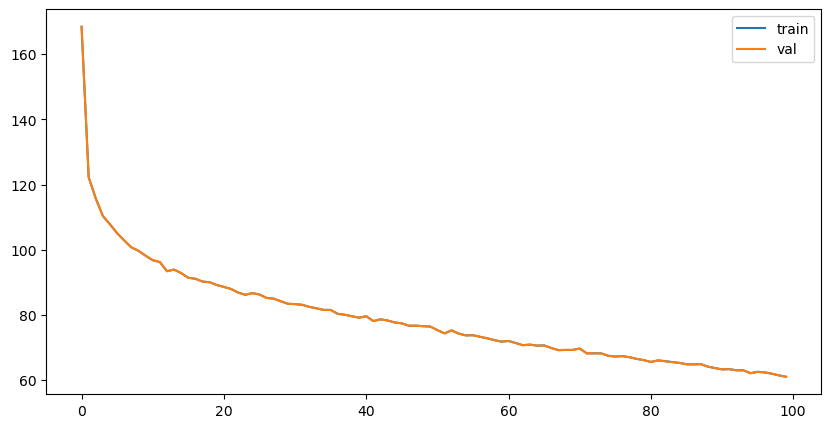

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_pd, label='train')
plt.plot(val_loss_pd, label='val')
plt.legend()

## Model evaluation

We define this function, which will be useful to evaluate the model.

In [21]:
def flatten(t):
    return [item for sublist in t for item in sublist]

We evaluate the model by using the first metric (mean absolute error). 

In [22]:
from sklearn.metrics import mean_absolute_error 
# from sklearn.metrics import root_mean_squared_error 

pred = model_with_attention.predict(X_test)
print(pred.shape)
print(len(flatten(pred)))
print(y_test.shape)
print(len(flatten(y_test)))

MAE = mean_absolute_error(flatten(pred),flatten(y_test))
print(MAE)
# RMSE = root_mean_squared_error(flatten(pred),flatten(y_test))
# print(RMSE)

324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
(10351, 1)
10351
(10351, 1)
10351
77.55508762766758


We will evaluate the model with the second metric (accuracy). For this, we divide target variable in three categories: first, data between percentil 0 and 15; second, data between percentil 15 and 85 and thrid, data between percentil 85 and 100. 

In [23]:
pred = model_with_attention.predict(X_test)
print(pred)

324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
[[ 83.01666]
 [700.76746]
 [161.28548]
 ...
 [409.43207]
 [943.9684 ]
 [267.84   ]]


In [24]:
y_test

array([[  95.],
       [ 825.],
       [ 190.],
       ...,
       [ 605.],
       [1051.],
       [ 293.]])

In [25]:
obj = list(data['obj'].values)

In [26]:
pred.dtype == np.float64
pred.dtype

dtype('float32')

In [27]:
print(np.quantile(obj, 0))
print(np.quantile(obj, 0.15))
print(np.quantile(obj, 0.85))
print(np.quantile(obj, 1))

0
70.0
840.0
3762


We add and substract a small value in extreme values in order to avoid issues. We also transform the predictions lower than 0 in 0. 

In [28]:
bins = [np.quantile(obj, 0)-0.001,np.quantile(obj, 0.15),np.quantile(obj, 0.85),np.quantile(obj, 1)+0.001]
names = ['a','b','c']
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
pred2=pd.cut(flatten(pred), bins, labels = names)
ytest2=pd.cut(flatten(y_test), bins, labels = names)

We obtain the accuracy metric and the confusion matrix corresponding. 

In [29]:
print(accuracy_score(ytest2,pred2))
print(confusion_matrix(ytest2,pred2))

0.8663897207999227
[[1366  182    0]
 [ 287 6547  328]
 [   0  586 1055]]


###  Plotting the actual and predicted values. 

We selelct randomly an observation of the entire dataset and we will analyse the 100 successive observations. We plot
the actual and the predicted values of these observations. 

In [30]:
np.random.seed(23)
rand = np.random.randint(0, 3000)
rand

# rand = randint(0, 30000, ran=1234)
# rand
X[rand:rand+100]

array([[[0.37844545, 0.2506372 , 0.27352473, ..., 0.21287128,
         0.6666667 , 0.8695652 ],
        [0.28504246, 0.21091759, 0.18022329, ..., 0.21287128,
         0.6666667 , 0.9130435 ],
        [0.25512737, 0.1539932 , 0.11297182, ..., 0.21287128,
         0.6666667 , 0.95652175],
        [0.21645983, 0.11214953, 0.07921319, ..., 0.21287128,
         0.6666667 , 1.        ]],

       [[0.28504246, 0.21091759, 0.18022329, ..., 0.21287128,
         0.6666667 , 0.9130435 ],
        [0.25512737, 0.1539932 , 0.11297182, ..., 0.21287128,
         0.6666667 , 0.95652175],
        [0.21645983, 0.11214953, 0.07921319, ..., 0.21287128,
         0.6666667 , 1.        ],
        [0.21188766, 0.0819881 , 0.06645402, ..., 0.22029702,
         0.6666667 , 0.        ]],

       [[0.25512737, 0.1539932 , 0.11297182, ..., 0.21287128,
         0.6666667 , 0.95652175],
        [0.21645983, 0.11214953, 0.07921319, ..., 0.21287128,
         0.6666667 , 1.        ],
        [0.21188766, 0.0819881 , 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


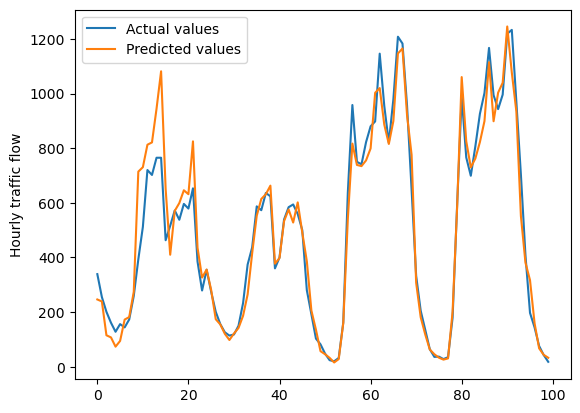

In [31]:
plt.plot(flatten(y[rand:rand+100]), label = "Actual values")
plt.plot(flatten(model_with_attention.predict(X[rand:rand+100])), label = "Predicted values")
plt.legend()
plt.ylabel('Hourly traffic flow')
plt.show()

In [32]:
import math

def calculate_rmse(actual_values, predicted_values):
    """
    Calculates the Root Mean Square Error (RMSE) given actual and predicted values.
    :param actual_values: List of actual observed values.
    :param predicted_values: List of predicted values.
    :return: RMSE value.
    """
    if len(actual_values) != len(predicted_values):
        raise ValueError("Lists must have the same length.")

    squared_errors = [(actual - predicted) ** 2 for actual, predicted in zip(actual_values, predicted_values)]
    mean_squared_error = sum(squared_errors) / len(actual_values)
    rmse = math.sqrt(mean_squared_error)
    return rmse


RMSE = calculate_rmse(flatten(pred),flatten(y_test))

In [33]:
print("MAE: ", MAE)
print("RMSE: ", RMSE)
print("Accuracy: ", accuracy_score(ytest2,pred2))

print("confusion matrix:\n ", confusion_matrix(ytest2,pred2))

MAE:  77.55508762766758
RMSE:  128.49289377730597
Accuracy:  0.8663897207999227
confusion matrix:
  [[1366  182    0]
 [ 287 6547  328]
 [   0  586 1055]]
